In [708]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
from joblib import dump
from matplotlib import pyplot
import random
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

### 1. Creación del DataFrame

In [710]:
# Setting the seed for reproducibility
np.random.seed(42)

In [711]:
estado_garantía_options = ['Dentro', 'Fuera', 'Extendida']
tipo_pago_options = ['contado', 'crédito']
serv_adicionales_options = ['frenos','suspensión', 'alineación', 'llantas', 'eléctricos','scanner', 'otros']
categoria_siniestro_options = ['siniestro', 'público']
tipo_contribuyente_options = ['p_física', 'p_moral']

In [712]:
estado_garantía = np.random.choice(estado_garantía_options, 10000)

In [713]:
años_en_servicio = np.where(estado_garantía == 'Dentro', np.random.choice([0, 1, 2, 3], size=len(estado_garantía)), np.random.choice([4, 5, 6, 7], size=len(estado_garantía)))

In [714]:
# Calculate 'año_modelo' based on 'años_en_servicio'
current_year = 2024
año_modelo = current_year - años_en_servicio

In [715]:
# Helper function to generate random values for num_mantenimientos
def generate_random_maintenance(años, multiplier_options):
    return np.random.choice(multiplier_options) * años

# Generate 'num_mantenimientos' array based on 'estado_garantía' and 'años_en_servicio'
num_mantenimientos = np.where(
    estado_garantía == 'Extendida', 
    [generate_random_maintenance(años, [4, 5, 6]) for años in años_en_servicio],
    np.where(
        estado_garantía == 'Dentro', 
        [generate_random_maintenance(años, [0, 1, 2, 3]) for años in años_en_servicio],
        np.random.choice([0,1,2, 3, 4, 5, 6], size=len(estado_garantía))
    )
)

In [716]:
última_fecha_entrada = []
for a, e, n in zip(año_modelo, estado_garantía, num_mantenimientos):
    start_date = pd.Timestamp(year=int(a), month=6, day=1)
    if e == 'Extendida':
        end_date = pd.Timestamp(year=int(a) + np.random.choice([4, 5, 6]), month=6, day=1)
    elif e == 'Dentro':
        end_date = pd.Timestamp(year=int(a) + np.random.choice([1, 2, 3]), month=6, day=1)
    elif e == 'Fuera':
        end_date = pd.Timestamp(year=int(a) + 3, month=6, day=1)
    if e in ['Extendida', 'Dentro']:
        if end_date > pd.Timestamp('2024-06-01'):
            date_range = pd.date_range(start=start_date, end=pd.Timestamp('2024-01-01'))
        else:
            date_range = pd.date_range(start=start_date, end=end_date)
    elif e == 'Fuera':
        date_range = pd.date_range(start=start_date, end=end_date)
    
    if not date_range.empty:
        última_fecha_entrada.append(np.random.choice(date_range))
    else:
        última_fecha_entrada.append(None)  # or handle the empty case as needed

In [717]:
len(última_fecha_entrada)

10000

In [718]:
# Create the 'año_modelo' DataFrame
df_año_modelo = pd.DataFrame({
    'id_cliente': range(1, 10001),
    'año_modelo': año_modelo,
    'última_fecha_entrada': última_fecha_entrada,
    'estado_garantía': estado_garantía
})

In [719]:
# Convert 'última_fecha_entrada' to datetime
df_año_modelo['última_fecha_entrada'] = pd.to_datetime(df_año_modelo['última_fecha_entrada'])

In [720]:
df_año_modelo['última_fecha_entrada'].size

10000

In [721]:
# Generate 'kilometraje' based on 'años_en_servicio'
kilometraje = np.maximum(20000 * años_en_servicio, 10000).astype(int)  # At least 20,000 per year

In [722]:
# Calculate 'dias_entre_' values
today = pd.Timestamp('2024-06-01')  # Assuming today's date for calculation
dias_entre_max = (today - df_año_modelo['última_fecha_entrada']).dt.days

In [723]:
# Generating 'dias_entre_mantenimientos' based on 'estado_garantía' and 'año_modelo'
dias_entre_mantenimientos = [
    np.random.randint(0, max(1, d - ((today.year - int(a)) * 365))) if e in ['Dentro', 'Extendida'] else np.random.randint(d // 2, max(1, d))
    for d, e, a in zip(dias_entre_max, estado_garantía, df_año_modelo['año_modelo'])
]

In [724]:
# Generating the main data
data = {
    "id_cliente": range(1, 10001),
    "kilometraje": kilometraje,
    "num_mantenimientos": num_mantenimientos,
    "monto_mantenimientos": np.random.normal(loc=60000, scale=3000, size=10000).astype(int),
    "num_serv_adicionales": np.random.choice([0, 1, 2, 3, 4, 5], 10000).astype(int),
    'categoria_serv_adicionales': np.random.choice(serv_adicionales_options, 10000),
    "monto_serv_adicionales": np.random.normal(loc=10000, scale=2000, size=10000).astype(int),
    "días_entre_serv_adicionales": [np.random.randint(0, max(1, d)) for d in dias_entre_max],
    "num_accesorios": np.random.choice([0, 1, 2, 3], 10000).astype(int),
    "monto_accesorios": np.random.normal(loc=9000, scale=1500, size=10000).astype(int),
    "días_entre_compra_accesorios": [np.random.randint(0, max(1, d)) for d in dias_entre_max],
    "num_hojalatería": np.random.choice([0, 1, 2, 3], 10000).astype(int),
    'monto_hojalatería': np.random.normal(loc=20000, scale=2500, size=10000).astype(int),
    #"num_pinturas": np.random.choice([0, 1, 2, 3], 5000).astype(int),
    #"num_cristales": np.random.choice([0, 1, 2], 5000).astype(int),
    #"num_piezas_adicionales": np.random.choice([0, 1, 2], 5000).astype(int),
    #"num_piezas_interiores": np.random.choice([0, 1, 2], 5000).astype(int),
    #"num_estética": np.random.choice([0, 1, 2], 5000).astype(int),
    'categoria_siniestro': np.random.choice(categoria_siniestro_options, 10000),
    "num_siniestros": np.random.choice([0, 1, 2, 3], 10000).astype(int),
    "monto_siniestros": np.random.normal(loc=20000, scale=2000, size=10000).astype(int),
    "días_entre_siniestros": [np.random.randint(0, max(1, d)) for d in dias_entre_max],
    "tipo_pago": np.random.choice(tipo_pago_options, 10000),
    "dias_entre_mantenimientos": dias_entre_mantenimientos,
    "tipo_contribuyente": np.random.choice(tipo_contribuyente_options,10000)
}

In [725]:
df_main = pd.DataFrame(data)

In [726]:
# Clipping the specified columns to ensure no negative values
for col in ["monto_mantenimientos", "monto_serv_adicionales", "monto_accesorios", "monto_siniestros", 'monto_hojalatería']:
    df_main[col] = np.clip(df_main[col], 0, None)

In [727]:
# Additional Calculations
df_main['promedio_monto_mantenimientos'] = df_main['monto_mantenimientos'] / df_main['num_mantenimientos']
df_main['promedio_serv_adicionales'] = df_main['monto_serv_adicionales'] / df_main['num_serv_adicionales']
df_main['promedio_monto_accesorios'] = df_main['monto_accesorios'] / df_main['num_accesorios']
df_main['promedio_monto_hojalatería'] = df_main['monto_hojalatería'] / df_main['num_hojalatería']
df_main['promedio_monto_siniestros'] = df_main['monto_siniestros'] /df_main['num_siniestros']

In [728]:
# Adjusting for zero counts
df_main.loc[df_main['num_mantenimientos'] == 0, ['monto_mantenimientos', 'promedio_monto_mantenimientos']] = 0
df_main.loc[df_main['num_serv_adicionales'] == 0, ['monto_serv_adicionales', 'promedio_serv_adicionales']] = 0
df_main.loc[df_main['num_siniestros'] == 0, ['monto_siniestros', 'promedio_monto_siniestros']] = 0
df_main.loc[df_main['num_accesorios'] == 0, ['monto_accesorios', 'promedio_monto_accesorios']] = 0
df_main.loc[df_main['num_hojalatería'] == 0, ['monto_hojalatería', 'promedio_monto_hojalatería']] = 0
df_main.loc[df_main["num_serv_adicionales"] == 0, ['categoria_serv_adicionales']] = "NA"

In [729]:
df_final = pd.merge(df_main, df_año_modelo, on='id_cliente')

In [730]:
df_final['última_fecha_entrada'].size

10000

In [731]:
df_final.head()

,id_cliente,kilometraje,num_mantenimientos,monto_mantenimientos,num_serv_adicionales,categoria_serv_adicionales,monto_serv_adicionales,días_entre_serv_adicionales,num_accesorios,monto_accesorios,...,dias_entre_mantenimientos,tipo_contribuyente,promedio_monto_mantenimientos,promedio_serv_adicionales,promedio_monto_accesorios,promedio_monto_hojalatería,promedio_monto_siniestros,año_modelo,última_fecha_entrada,estado_garantía
0,1,120000,24,63010,3,otros,8046,758,3,8051,...,0,p_física,2625.416667,2682.0,2683.666667,7638.666667,24793.0,2018,2021-05-06,Extendida
1,2,20000,0,0,3,suspensión,12885,141,2,8509,...,0,p_física,0.000000,4295.0,4254.500000,0.000000,0.0,2023,2023-08-24,Dentro
2,3,80000,24,62858,1,alineación,10563,379,0,0,...,0,p_física,2619.083333,10563.0,0.000000,7896.333333,21811.0,2020,2022-09-26,Extendida
3,4,120000,24,59001,0,NA,0,311,0,0,...,0,p_moral,2458.375000,0.0,0.000000,5899.666667,10192.0,2018,2020-11-22,Extendida
4,5,10000,0,0,5,scanner,5525,0,2,11872,...,0,p_física,0.000000,1105.0,5936.000000,12658.000000,0.0,2024,NaT,Dentro


In [732]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id_cliente                     10000 non-null  int64         
 1   kilometraje                    10000 non-null  int32         
 2   num_mantenimientos             10000 non-null  int32         
 3   monto_mantenimientos           10000 non-null  int32         
 4   num_serv_adicionales           10000 non-null  int32         
 5   categoria_serv_adicionales     10000 non-null  object        
 6   monto_serv_adicionales         10000 non-null  int32         
 7   días_entre_serv_adicionales    10000 non-null  int64         
 8   num_accesorios                 10000 non-null  int32         
 9   monto_accesorios               10000 non-null  int32         
 10  días_entre_compra_accesorios   10000 non-null  int64         
 11  num_hojalatería 

In [733]:
df_final.isna().sum()

id_cliente                         0
kilometraje                        0
num_mantenimientos                 0
monto_mantenimientos               0
num_serv_adicionales               0
categoria_serv_adicionales         0
monto_serv_adicionales             0
días_entre_serv_adicionales        0
num_accesorios                     0
monto_accesorios                   0
días_entre_compra_accesorios       0
num_hojalatería                    0
monto_hojalatería                  0
categoria_siniestro                0
num_siniestros                     0
monto_siniestros                   0
días_entre_siniestros              0
tipo_pago                          0
dias_entre_mantenimientos          0
tipo_contribuyente                 0
promedio_monto_mantenimientos      0
promedio_serv_adicionales          0
promedio_monto_accesorios          0
promedio_monto_hojalatería         0
promedio_monto_siniestros          0
año_modelo                         0
última_fecha_entrada             862
e

In [734]:
df_final.dropna()

,id_cliente,kilometraje,num_mantenimientos,monto_mantenimientos,num_serv_adicionales,categoria_serv_adicionales,monto_serv_adicionales,días_entre_serv_adicionales,num_accesorios,monto_accesorios,...,dias_entre_mantenimientos,tipo_contribuyente,promedio_monto_mantenimientos,promedio_serv_adicionales,promedio_monto_accesorios,promedio_monto_hojalatería,promedio_monto_siniestros,año_modelo,última_fecha_entrada,estado_garantía
0,1,120000,24,63010,3,otros,8046,758,3,8051,...,0,p_física,2625.416667,2682.000000,2683.666667,7638.666667,24793.0,2018,2021-05-06,Extendida
1,2,20000,0,0,3,suspensión,12885,141,2,8509,...,0,p_física,0.000000,4295.000000,4254.500000,0.000000,0.0,2023,2023-08-24,Dentro
2,3,80000,24,62858,1,alineación,10563,379,0,0,...,0,p_física,2619.083333,10563.000000,0.000000,7896.333333,21811.0,2020,2022-09-26,Extendida
3,4,120000,24,59001,0,NA,0,311,0,0,...,0,p_moral,2458.375000,0.000000,0.000000,5899.666667,10192.0,2018,2020-11-22,Extendida
5,6,60000,6,61110,5,otros,9040,362,3,6678,...,0,p_moral,10185.000000,1808.000000,2226.000000,8225.000000,8330.0,2021,2021-12-11,Dentro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,80000,16,59032,1,frenos,7794,1078,3,7521,...,0,p_moral,3689.500000,7794.000000,2507.000000,6469.000000,8949.0,2020,2020-08-29,Extendida
9996,9997,20000,0,0,3,otros,10790,82,1,6542,...,0,p_física,0.000000,3596.666667,6542.000000,8383.000000,9797.0,2023,2023-12-16,Dentro
9997,9998,140000,0,0,0,NA,0,251,1,8752,...,1350,p_física,0.000000,0.000000,8752.000000,9768.500000,8398.0,2017,2019-01-06,Fuera
9998,9999,80000,5,59706,0,NA,0,295,0,0,...,404,p_moral,11941.200000,0.000000,0.000000,8351.666667,22055.0,2020,2023-02-07,Fuera


### 2. Análisis Exploratorio de Datos

In [736]:
df_final.groupby(['año_modelo']).size().reset_index(name='Counts')

,año_modelo,Counts
0,2017,1639
1,2018,1657
2,2019,1690
3,2020,1660
4,2021,869
5,2022,796
6,2023,827
7,2024,862


In [737]:
grouped_count = df_final.groupby(['estado_garantía']).size().reset_index(name='Counts')

C:\Users\festu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\festu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\festu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


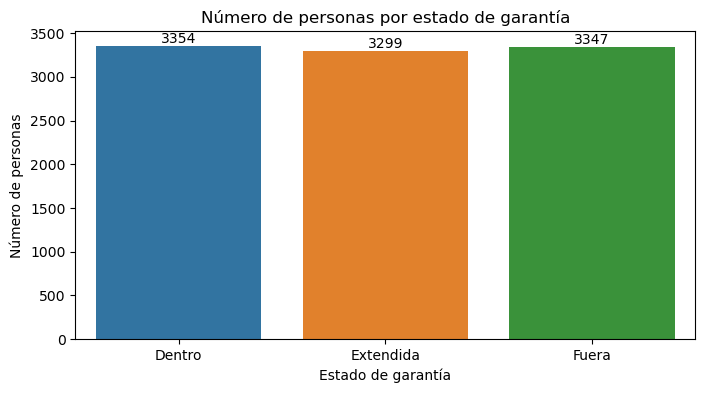

In [738]:
# Create the bar chart
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=grouped_count, x='estado_garantía', y='Counts')

# Add annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('Número de personas por estado de garantía')
plt.ylabel('Número de personas')
plt.xlabel('Estado de garantía')
plt.show()

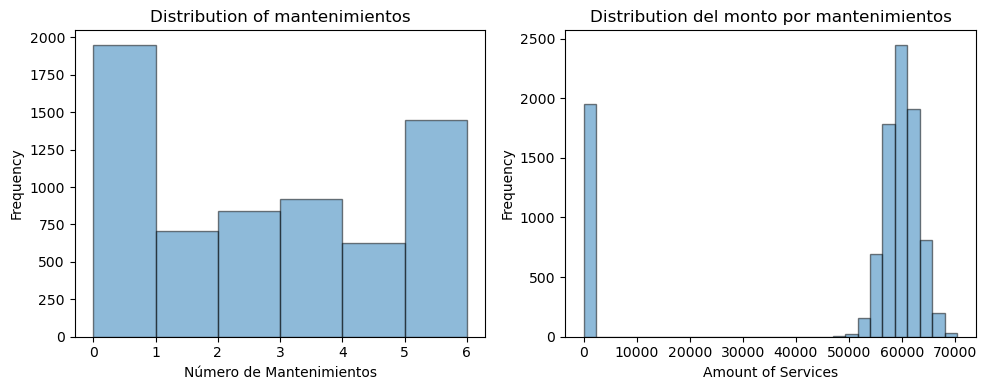

In [739]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['num_mantenimientos'], bins=range(7), edgecolor='black', alpha=0.5)
plt.title('Distribution of mantenimientos')
plt.xlabel('Número de Mantenimientos')
plt.ylabel('Frequency')

# Plot the distribution of monto_servicios
plt.subplot(1, 2, 2)
plt.hist(df_final['monto_mantenimientos'], bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribution del monto por mantenimientos')
plt.xlabel('Amount of Services')
plt.ylabel('Frequency')

plt.tight_layout()

# Show the plot
plt.show()

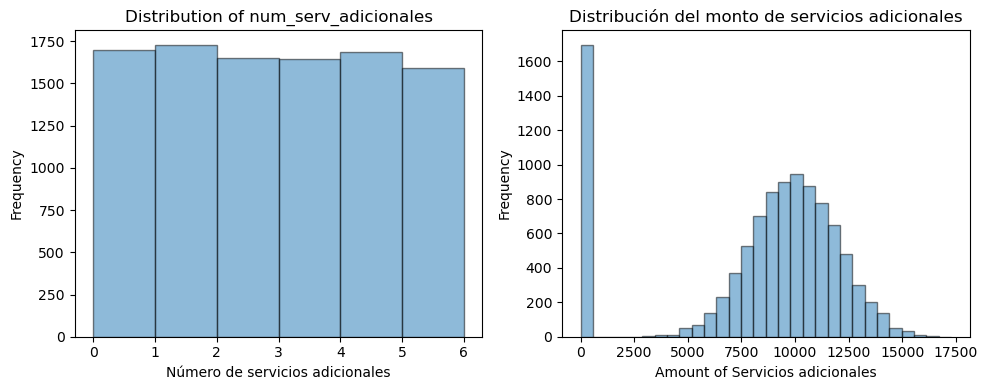

In [740]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['num_serv_adicionales'], bins=range(7), edgecolor='black', alpha=0.5)
plt.title('Distribution of num_serv_adicionales')
plt.xlabel('Número de servicios adicionales')
plt.ylabel('Frequency')

# Plot the distribution of monto_servicios
plt.subplot(1, 2, 2)
plt.hist(df_final['monto_serv_adicionales'], bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribución del monto de servicios adicionales')
plt.xlabel('Amount of Servicios adicionales')
plt.ylabel('Frequency')

plt.tight_layout()

# Show the plot
plt.show()

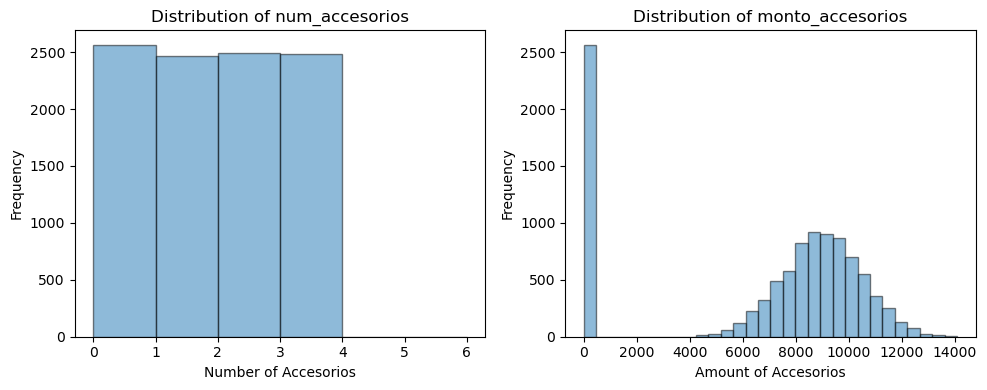

In [741]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['num_accesorios'], bins=range(7), edgecolor='black', alpha=0.5)
plt.title('Distribution of num_accesorios')
plt.xlabel('Number of Accesorios')
plt.ylabel('Frequency')

# Plot the distribution of monto_servicios
plt.subplot(1, 2, 2)
plt.hist(df_final['monto_accesorios'], bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribution of monto_accesorios')
plt.xlabel('Amount of Accesorios')
plt.ylabel('Frequency')

plt.tight_layout()

# Show the plot
plt.show()

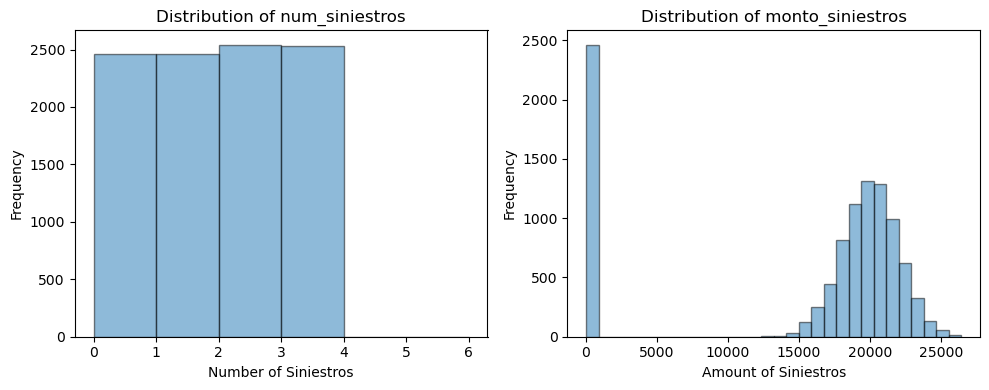

In [742]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['num_siniestros'], bins=range(7), edgecolor='black', alpha=0.5)
plt.title('Distribution of num_siniestros')
plt.xlabel('Number of Siniestros')
plt.ylabel('Frequency')

# Plot the distribution of monto_servicios
plt.subplot(1, 2, 2)
plt.hist(df_final['monto_siniestros'], bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribution of monto_siniestros')
plt.xlabel('Amount of Siniestros')
plt.ylabel('Frequency')

plt.tight_layout()

# Show the plot
plt.show()

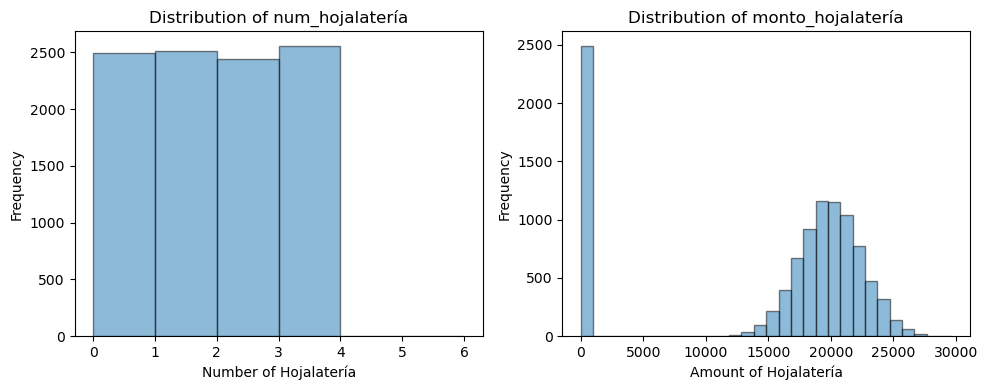

In [743]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_final['num_hojalatería'], bins=range(7), edgecolor='black', alpha=0.5)
plt.title('Distribution of num_hojalatería')
plt.xlabel('Number of Hojalatería')
plt.ylabel('Frequency')

# Plot the distribution of monto_servicios
plt.subplot(1, 2, 2)
plt.hist(df_final['monto_hojalatería'], bins=30, edgecolor='black', alpha=0.5)
plt.title('Distribution of monto_hojalatería')
plt.xlabel('Amount of Hojalatería')
plt.ylabel('Frequency')

plt.tight_layout()

# Show the plot
plt.show()

### 3. Conversión y escalación de datos

In [745]:
# Preprocessing: Convert categorical columns to numeric
df_final['estado_garantía'] = df_final['estado_garantía'].map({'Dentro': 0, 'Fuera': 1, 'Extendida': 2})
df_final['tipo_pago'] = df_final['tipo_pago'].map({'contado': 0, 'crédito': 1, 'meses': 2, 'préstamo': 3})
df_final['categoria_serv_adicionales'] = df_final['categoria_serv_adicionales'].map({'NA': 0, 'frenos': 1, 'suspensión': 2, 'alineación': 3, 'llantas': 4, 'eléctricos': 5,'scanner':6, 'otros':7})
df_final['categoria_siniestro'] = df_final['categoria_siniestro'].map({'siniestro': 0, 'público': 1 })
df_final['tipo_contribuyente'] = df_final['tipo_contribuyente'].map({'p_física': 0, 'p_moral': 1 })

# Dropping the original categorical columns from the original DataFrame
data_for_model = df_final.drop(["id_cliente", "última_fecha_entrada"], axis=1)

# Concatenating the encoded DataFrame with the remaining original DataFrame
data_for_model.head()


,kilometraje,num_mantenimientos,monto_mantenimientos,num_serv_adicionales,categoria_serv_adicionales,monto_serv_adicionales,días_entre_serv_adicionales,num_accesorios,monto_accesorios,días_entre_compra_accesorios,...,tipo_pago,dias_entre_mantenimientos,tipo_contribuyente,promedio_monto_mantenimientos,promedio_serv_adicionales,promedio_monto_accesorios,promedio_monto_hojalatería,promedio_monto_siniestros,año_modelo,estado_garantía
0,120000,24,63010,3,7,8046,758,3,8051,258,...,0,0,0,2625.416667,2682.0,2683.666667,7638.666667,24793.0,2018,2
1,20000,0,0,3,2,12885,141,2,8509,97,...,0,0,0,0.000000,4295.0,4254.500000,0.000000,0.0,2023,0
2,80000,24,62858,1,3,10563,379,0,0,279,...,0,0,0,2619.083333,10563.0,0.000000,7896.333333,21811.0,2020,2
3,120000,24,59001,0,0,0,311,0,0,1003,...,0,0,1,2458.375000,0.0,0.000000,5899.666667,10192.0,2018,2
4,10000,0,0,5,6,5525,0,2,11872,0,...,1,0,0,0.000000,1105.0,5936.000000,12658.000000,0.0,2024,0


In [746]:
data_for_model.isna().sum()

kilometraje                      0
num_mantenimientos               0
monto_mantenimientos             0
num_serv_adicionales             0
categoria_serv_adicionales       0
monto_serv_adicionales           0
días_entre_serv_adicionales      0
num_accesorios                   0
monto_accesorios                 0
días_entre_compra_accesorios     0
num_hojalatería                  0
monto_hojalatería                0
categoria_siniestro              0
num_siniestros                   0
monto_siniestros                 0
días_entre_siniestros            0
tipo_pago                        0
dias_entre_mantenimientos        0
tipo_contribuyente               0
promedio_monto_mantenimientos    0
promedio_serv_adicionales        0
promedio_monto_accesorios        0
promedio_monto_hojalatería       0
promedio_monto_siniestros        0
año_modelo                       0
estado_garantía                  0
dtype: int64

In [747]:
# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_for_model)

scaled_features.shape

(10000, 26)

### 4. Ajuste del modelo

C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

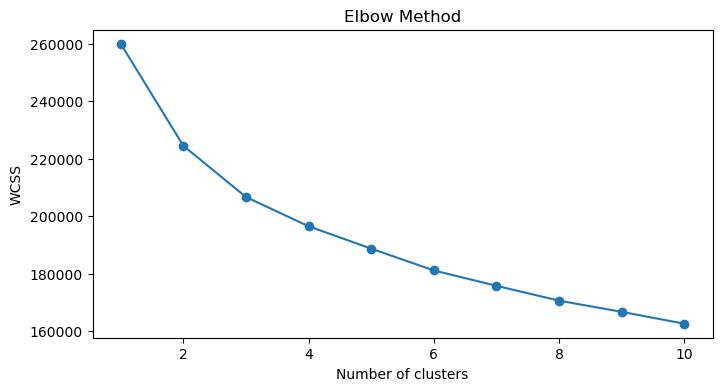

In [749]:
# Elbow Method to find the optimal number of clusters
wcss = []

# Run K-means for a range of cluster numbers (e.g., 1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    
# Plot WCSS vs. number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

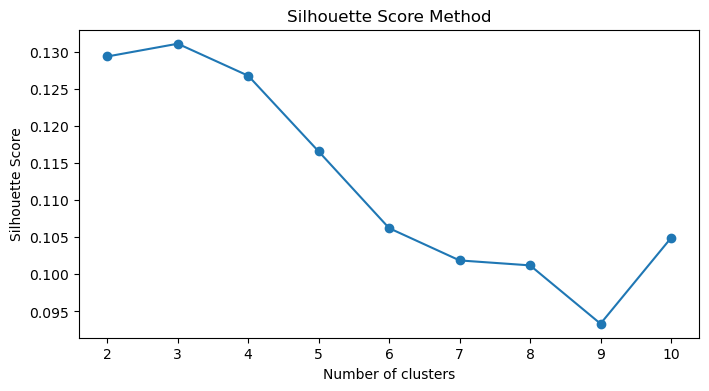

In [750]:
# Silhouette Score to evaluate the optimal number of clusters
silhouette_scores = []

# Run K-means for a range of cluster numbers (e.g., 2 to 10)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_features, labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores vs. number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [751]:
# Initialize the KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the scaled data
data_for_model['cluster'] = kmeans.fit_predict(scaled_features)

data_for_model.shape

C:\Users\festu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(10000, 27)

In [752]:
# Inverse transform the cluster centers to original scale
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=data_for_model.drop(['cluster'],axis=1).columns)

# Print the cluster centers
cluster_centers_df.shape

(3, 26)

### 5. Creación del modelo KNN

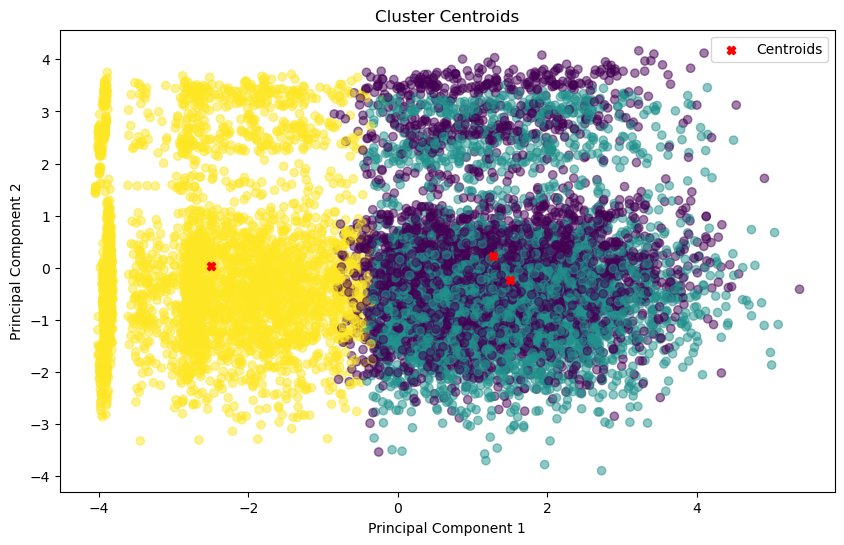

In [754]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Plot cluster centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data_for_model['cluster'], cmap='viridis', marker='o', alpha=0.5)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], color='red', marker='X', label='Centroids')
plt.title('Cluster Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [755]:
print(centroids_pca[:, 0])
print(centroids_pca[:, 1])

[ 1.27612479  1.50490091 -2.49507507]
[ 0.22333009 -0.24095049  0.02756021]


### 6. Visualización de los parámetros principales

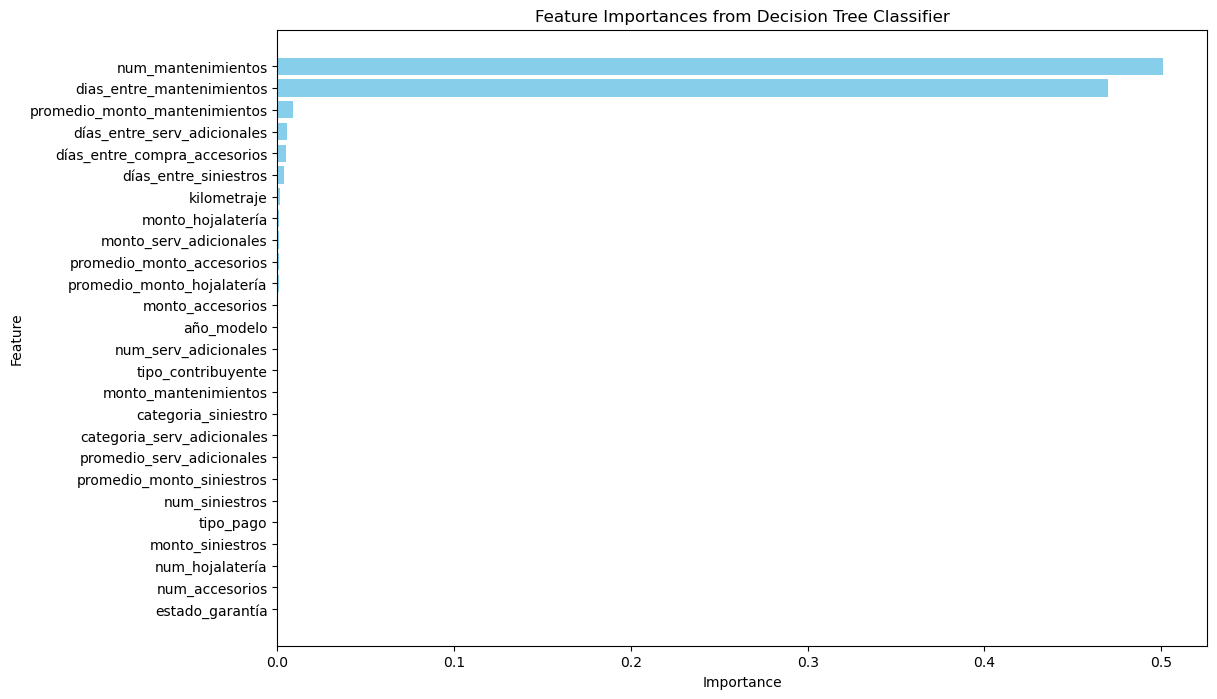

In [757]:
# Preparing the data
X = data_for_model.drop(columns=["cluster"])
y = data_for_model['cluster']

# Train the decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X, y)

# Extract feature importances
feature_importances = tree_clf.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()
plt.show()

In [758]:
# Calculate mean feature values per cluster
cluster_means = data_for_model.groupby('cluster').mean()

# Calculate the difference from the overall mean
overall_means = data_for_model.mean()
diff_from_overall = cluster_means - overall_means

# Identify top features that differentiate each cluster
top_features_per_cluster = diff_from_overall.abs().idxmax(axis=1)

# Extract top features and their differences for a detailed description
top_features = diff_from_overall.abs().max(axis=1)
description_df = pd.DataFrame({
    'Cluster': diff_from_overall.index,
    'Top Feature': top_features_per_cluster,
    'Importance': top_features
}).sort_values(by='Importance', ascending=False)

#tools.display_dataframe_to_user(name="Top Features Describing Each Cluster", dataframe=description_df)

description_df.sort_values(by = "Importance")

,Cluster,Top Feature,Importance
cluster,,,
1,1,kilometraje,25703.159745
0,0,kilometraje,28264.401153
2,2,kilometraje,48326.234637


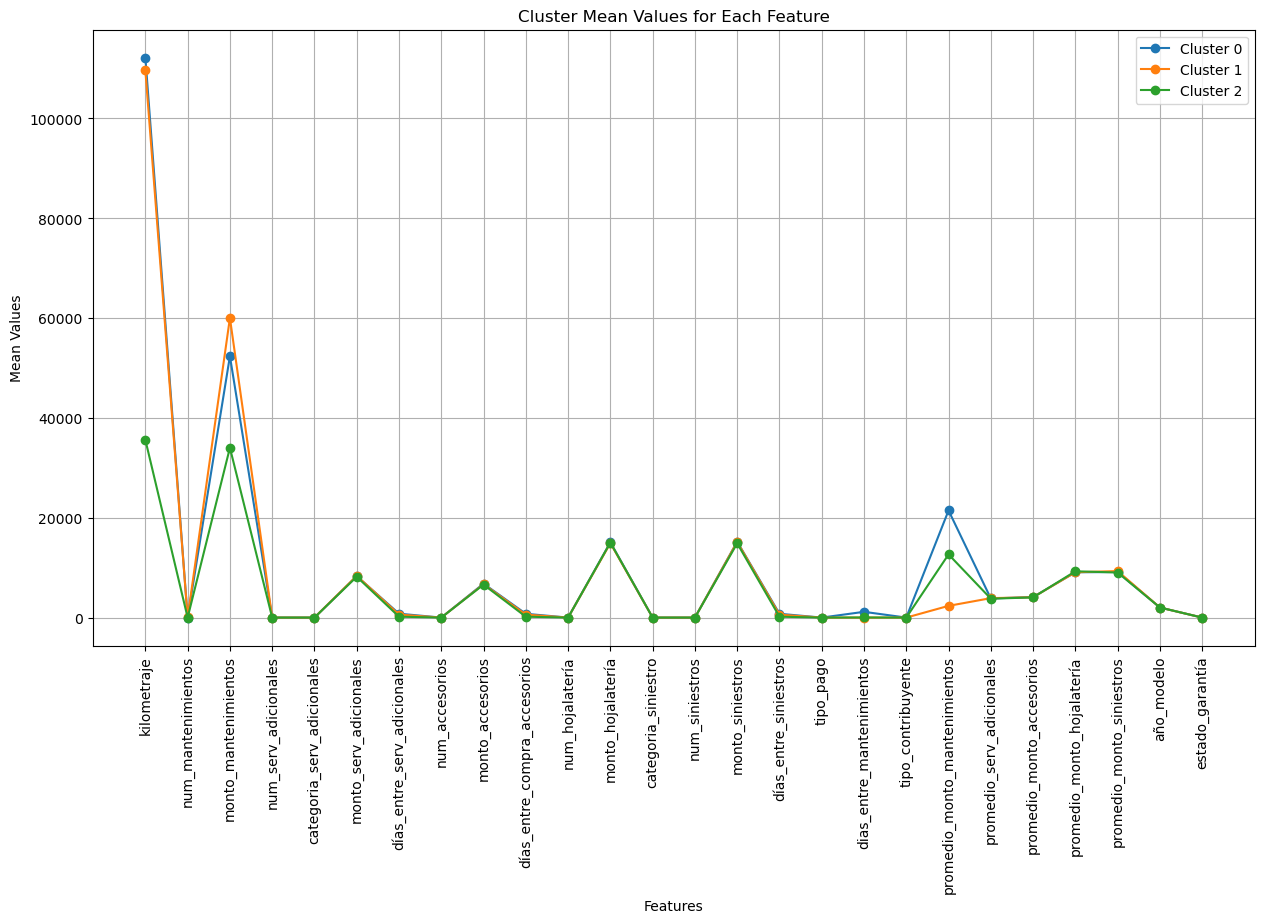

In [759]:
# Plotting cluster means
plt.figure(figsize=(15, 8))

for i in range(cluster_means.shape[0]):
    plt.plot(cluster_means.columns, cluster_means.iloc[i], marker='o', linestyle='-', label=f'Cluster {i}')

plt.xlabel('Features')
plt.ylabel('Mean Values')
plt.title('Cluster Mean Values for Each Feature')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [760]:
df_final['Customer_Category'] = data_for_model['cluster'].map({
    0: 'Category 1',
    1: 'Category 2',
    2: 'Category 3',
    3: 'Category 4',
    4: 'Category 5',
    5: 'Category 6',
})

In [761]:
df_final['estado_garantía'] = df_final['estado_garantía'].map({0: 'Dentro', 1: 'Fuera', 2: 'Extendida' })
df_final['tipo_pago'] = df_final['tipo_pago'].map({0: 'contado' , 1: 'crédito' , 2: 'meses' , 3: 'préstamo' })
df_final['categoria_serv_adicionales'] = df_final['categoria_serv_adicionales'].map({0: 'NA', 1: 'frenos' , 2: 'suspensión' , 3: 'alineación' , 4: 'llantas' , 5: 'eléctricos' ,6: 'scanner', 7: 'otros' })
df_final['categoria_siniestro'] = df_final['categoria_siniestro'].map({0: 'seguro' , 1: 'público'})
df_final['tipo_contribuyente'] = df_final['tipo_contribuyente'].map({0:'p_física', 1:'p_moral'})

In [762]:
df_final.to_csv('Clientes postventa.csv', index=False)